In [1]:
from dotenv import load_dotenv
from pathlib import Path
import sys


sys.path.append(Path(".").resolve().as_posix())
_ = load_dotenv()

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np

In [91]:
class ResBlock_v1(nn.Module):
    def __init__(self, chan):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(chan, chan, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(chan, chan, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(chan, chan, 1),
        )

    def forward(self, x):
        return self.net(x) + x


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # NUM_DOWNSAMPLE_LAYERS = 4
        num_resnet_blocks = 2
        codebook_dim = 512  # ???
        num_downsample_layers = 4
        layer_num = num_downsample_layers - 1
        dim = 16
        channels = 1
        num_embeddings = 128
        self.embedding_dim = 512

        enc_layers = [nn.Conv2d(channels, dim, 4, stride=2, padding=1), nn.ReLU()]

        for i in range(layer_num):
            enc_layers.append(nn.Conv2d(dim, dim * 2, 4, stride=2, padding=1))
            enc_layers.append(nn.ReLU())
            dim = dim * 2

        for i in range(num_resnet_blocks):
            enc_layers.append(ResBlock_v1(dim))
        enc_layers.append(nn.Conv2d(dim, codebook_dim, 1))

        self.encoder = nn.Sequential(*enc_layers)
        self.embedding = nn.Embedding(num_embeddings, self.embedding_dim)

    # def norm(self, images):
    #     images = 2.0 * (images / self.max_value - 0.5)
    #     return images

    def norm(self, x):
        return 2.0 * (x - 0.5)

    def forward(self, img):
        # label_img = img.clone().float()  # if label_img is None else label_img.float()

        # print(img.shape)

        img = img.float()

        img = self.norm(img)
        # label_img = self.norm(label_img)

        logits = self.encoder(img)
        # print(logits.shape)

        inputs = logits
        # print("shape ", inputs.shape)

        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        # print(inputs.shape)

        # input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)

        # print(flat_input.shape)

        # Calculate distances
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.embedding.weight.t())
        )

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1)#.unsqueeze(1)
        # print(encoding_indices.shape)

        return encoding_indices


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        num_resnet_blocks = 2
        dim = 128
        codebook_dim = 512  # ???
        num_upsample_layers = 4
        layer_num = num_upsample_layers - 1
        channels = 1

        self.num_embeddings = 128
        self.embedding_dim = 512

        dec_layers = [nn.Conv2d(codebook_dim, dim, 1), nn.ReLU()]

        for i in range(num_resnet_blocks):
            dec_layers.append(ResBlock_v1(dim))

        dec_layers.append(nn.ConvTranspose2d(dim, dim, 4, stride=2, padding=1))
        dec_layers.append(nn.ReLU())
        for i in range(layer_num):
            dec_layers.append(nn.ConvTranspose2d(dim, dim // 2, 4, stride=2, padding=1))
            dec_layers.append(nn.ReLU())
            dim = dim // 2
        dec_layers.append(nn.Conv2d(dim, channels, 1))
        self.decoder = nn.Sequential(*dec_layers)

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)

    def forward(self, encoding_indices):

        # encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings)
        # print(encodings.shape)
        # print(encodings.dtype)

        # print(encoding_indices.max())

        # encodings.scatter_(1, encoding_indices, 1)
        # print(encodings.shape)
        # print(encodings)

        # Quantize and unflatten
        # quantized = torch.matmul(encodings, self.embedding.weight).view([1, 512, 4, 4])  # .view(input_shape)

        quantized = self.embedding.weight[encoding_indices].clone()
        print(quantized.t().shape)

        # print(quantized.shape)
        out = self.decoder(quantized.t().view([1, 512, 4, 4]))
        # print(out.shape)
        return out


MODEL_PATH = "vae-oid.npz"


with open(MODEL_PATH, "rb") as f:
    np_state_dict = dict(np.load(f))


encoder_state_dict = {}

for key, weight in np_state_dict.items():
    if "encoder." in key:
        encoder_state_dict[key] = torch.tensor(weight)

    if "embedding" in key:
        encoder_state_dict["embedding.weight"] = torch.tensor(weight)

encoder_model = Encoder()
encoder_model.load_state_dict(encoder_state_dict)


decoder_state_dict = {}

for key, weight in np_state_dict.items():
    if "decoder." in key:
        decoder_state_dict[key] = torch.tensor(weight)

    if "embedding" in key:
        decoder_state_dict["embedding.weight"] = torch.tensor(weight)

decoder_model = Decoder()
decoder_model.load_state_dict(decoder_state_dict)

<All keys matched successfully>

In [92]:
# # convert quantized from BHWC -> BCHW
# return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices.view(input_shape[0:3])

In [93]:
import os
import supervision as sv
from torchvision.transforms.functional import resize

dataset_path = "TACO/data/batch_1"

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_path}",
    annotations_path=f"{dataset_path}/annotations.json",
    force_masks=True,
)

seg_tokens = np.array(["<seg%03d>" % i for i in range(128)])
loc_tokens = np.array(["<loc%04d>" % i for i in range(1024)])

labels = []
prefix = "segment " + " ; ".join(ds.classes)

for image_path, image, annotations in ds:
    h, w, _ = image.shape

    image_name = os.path.basename(image_path)
    suffix_components = []

    # print(annotations)

    if (
        annotations.xyxy is None
        or annotations.mask is None
        or annotations.class_id is None
    ):
        print("broken sample")
        continue

    for xyxy, mask, class_id in zip(
        annotations.xyxy, annotations.mask, annotations.class_id
    ):

        y1 = xyxy[1].astype(np.int32)
        x1 = xyxy[0].astype(np.int32)
        y2 = xyxy[3].astype(np.int32)
        x2 = xyxy[2].astype(np.int32)

        mask = torch.tensor(mask.astype(np.uint8), dtype=torch.uint8)

        # print(mask.shape)

        # print(mask[y1:y2, x1:x2].shape)

        # print(y1, x1, y2, x2) 
        mask = resize(
            # mask[None, y1:y2, x1:x2, None],
            mask[y1:y2, x1:x2].unsqueeze(0),
            [64, 64],
            # interpolation="bilinear",
            antialias=True,
        )

        mask_indices = encoder_model(mask.unsqueeze(0)).numpy()

        # mask_indices = encode_to_codebook_indices(checkpoint, mask)[0]
        mask_string = np.take(seg_tokens, mask_indices)

        bbox = xyxy[[1, 0, 3, 2]] / np.array([h, w, h, w])
        binned_loc = (bbox * 1023).astype(np.int32)
        binned_loc = np.clip(binned_loc, 0, 1023)
        loc_string = np.take(loc_tokens, binned_loc)

        # print(loc_string)
        # print(mask_string)

        suffix_part = "".join(np.concatenate([loc_string, mask_string]).tolist())
        suffix_part = f"{suffix_part} {ds.classes[class_id]}"
        suffix_components.append(suffix_part)
        # print(suffix)

    suffix = " ; ".join(suffix_components)
    labels.append({"image": image_name, "prefix": prefix, "suffix": suffix})

In [94]:
labels[1]

{'image': '000008.jpg',
 'prefix': 'segment Aluminium foil ; Battery ; Aluminium blister pack ; Carded blister pack ; Other plastic bottle ; Clear plastic bottle ; Glass bottle ; Plastic bottle cap ; Metal bottle cap ; Broken glass ; Food Can ; Aerosol ; Drink can ; Toilet tube ; Other carton ; Egg carton ; Drink carton ; Corrugated carton ; Meal carton ; Pizza box ; Paper cup ; Disposable plastic cup ; Foam cup ; Glass cup ; Other plastic cup ; Food waste ; Glass jar ; Plastic lid ; Metal lid ; Other plastic ; Magazine paper ; Tissues ; Wrapping paper ; Normal paper ; Paper bag ; Plastified paper bag ; Plastic film ; Six pack rings ; Garbage bag ; Other plastic wrapper ; Single-use carrier bag ; Polypropylene bag ; Crisp packet ; Spread tub ; Tupperware ; Disposable food container ; Foam food container ; Other plastic container ; Plastic glooves ; Plastic utensils ; Pop tab ; Rope & strings ; Scrap metal ; Shoe ; Squeezable tube ; Plastic straw ; Paper straw ; Styrofoam piece ; Unlabe

In [95]:
## Postprocessing Utils for Segmentation Tokens
### Segmentation tokens are passed to another VAE which decodes them to a mask
import re
import cv2
from typing import Tuple, Optional
import cv2
import json
import supervision as sv
from typing import List
import PIL


_MODEL_PATH = "vae-oid.npz"

_SEGMENT_DETECT_RE = re.compile(
    r"(.*?)"
    + r"<loc(\d{4})>" * 4
    + r"\s*"
    + "(?:%s)?" % (r"<seg(\d{3})>" * 16)
    + r"\s*([^;<>]+)? ?(?:; )?",
)

torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])


torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size([512, 16])
torch.Size

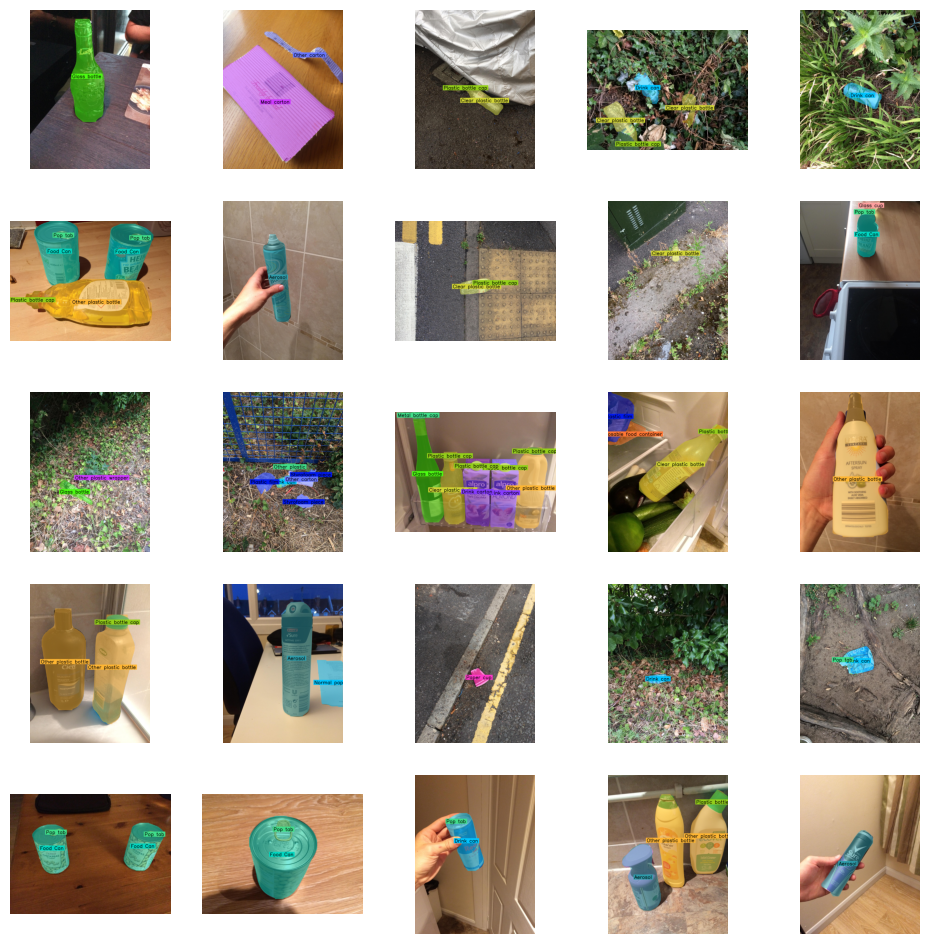

In [96]:
def extract_objs(text, width, height, unique_labels=False):
    """Returns objs for a string with "<loc>" and "<seg>" tokens."""
    objs = []
    seen = set()
    while text:
        m = _SEGMENT_DETECT_RE.match(text)
        if not m:
            break
        # print("m", m)
        gs = list(m.groups())

        before = gs.pop(0)
        name = gs.pop()
        y1, x1, y2, x2 = [int(x) / 1024 for x in gs[:4]]

        y1, x1, y2, x2 = map(round, (y1 * height, x1 * width, y2 * height, x2 * width))
        seg_indices = gs[4:20]
        if seg_indices[0] is None:
            mask = None
        else:
            seg_indices = np.array([int(x) for x in seg_indices], dtype=np.int32)

            seg_indices = torch.tensor(seg_indices, dtype=torch.int64)

            m64 = decoder_model(seg_indices).squeeze().detach().numpy()
            m64 = np.clip(np.array(m64) * 0.5 + 0.5, 0, 1)



            m64 = PIL.Image.fromarray((m64 * 255).astype("uint8"))

            
            mask = np.zeros([height, width])
            if y2 > y1 and x2 > x1:
                mask[y1:y2, x1:x2] = np.array(m64.resize([x2 - x1, y2 - y1])) / 255.0

        content = m.group()
        if before:
            objs.append(dict(content=before))
            content = content[len(before) :]
        while unique_labels and name in seen:
            name = (name or "") + "'"
        seen.add(name)
        objs.append(dict(content=content, xyxy=(x1, y1, x2, y2), mask=mask, name=name))
        text = text[len(before) + len(content) :]

    if text:
        objs.append(dict(content=text))

    return objs


def from_paligemma(text: str, resolution_wh: Tuple[int, int], classes: List[str]) -> sv.Detections:
    w, h = resolution_wh
    results = extract_objs(text, w, h)

    xyxy = []
    mask = []
    class_id = []
    class_name = []

    for r in results:
        xyxy.append(r['xyxy'])
        _, m = cv2.threshold(r['mask'], 0.5, 1.0, cv2.THRESH_BINARY)
        mask.append(m)
        class_id.append(classes.index(r['name'].strip()))
        class_name.append(r['name'].strip())

    detections = sv.Detections(
        xyxy=np.array(xyxy).astype(int),
        mask=np.array(mask).astype(bool),
        class_id=np.array(class_id).astype(int)
    )

    detections['class_name'] = class_name
    return detections


images = []

for label in labels[:25]:
    suffix = label["suffix"]
    image_name = label["image"]
    image = cv2.imread(f"{dataset_path}/{image_name}")
    (h, w, _) = image.shape
    detections = from_paligemma(
        text=suffix,
        resolution_wh=(w, h),
        classes=ds.classes)

    image = sv.MaskAnnotator().annotate(image, detections)
    mage = sv.LabelAnnotator(text_scale=2, text_thickness=4, text_position=sv.Position.CENTER_OF_MASS, text_color=sv.Color.BLACK).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))